# Delivery Route Optimization using RL and Informed Search

## Overview
This script evaluates and compares a variety of algorithms for solving the delivery route optimization problem. It uses a unified pipeline to test:
1.  **Reinforcement Learning Agents**: Q-Learning, SARSA, and DQN.
2.  **Informed Search Agents**: A* Search and Greedy Best-First Search.
#
The script uses `osmnx` to calculate real road network distances and leverages a Google AI model to provide a final analysis and explanation of the results.

In [4]:
import os
import time

import folium
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
from dotenv import load_dotenv

print("All libraries imported successfully!")
try:
    import osmnx as ox
    import networkx as nx

    OSMNX_AVAILABLE = True
except ImportError:
    OSMNX_AVAILABLE = False

from ai_models import *
from world import *

if not OSMNX_AVAILABLE:
    print("\nWARNING: OSMnx is not available. The 'network' distance metric will fail.")
    print("Please install with: pip install osmnx")



All libraries imported successfully!


### Visualization and Helper Functions

In [5]:
def plot_delivery_route(env, route, file_path, agent_name=""):
    """
    Creates an interactive Folium map of the delivery route, showing the order of stops
    and layering the road network path over the straight-line path.
    """
    locations = env.locations
    if not isinstance(locations, np.ndarray) or locations.size == 0:
        print(f"    Cannot plot route for {file_path}: No locations provided.")
        return None

    map_center = np.mean(locations, axis=0)
    m = folium.Map(location=map_center, zoom_start=12, tiles="cartodbpositron")

    title_html = f'<h3 align="center" style="font-size:16px"><b>Route for {agent_name}</b></h3>'
    m.get_root().html.add_child(folium.Element(title_html))

    # Depot Marker
    folium.Marker(
        locations[0],
        popup="Depot",
        tooltip="DEPOT (Start/End)",
        icon=folium.Icon(color="red", icon="warehouse", prefix="fa")
    ).add_to(m)

    # Delivery Stop Markers with Numbers
    for i, loc_index in enumerate(route):
        if i == 0 or i == len(route) - 1:  # Skip depot
            continue
        folium.Marker(
            locations[loc_index],
            popup=f"Stop {i}: Location {loc_index}",
            tooltip=f"Stop #{i}",
            icon=folium.DivIcon(
                html=f'<div style="font-family: sans-serif; background-color: #3388ff; color: white; border-radius: 50%; width: 24px; height: 24px; text-align: center; line-height: 24px; font-weight: bold;">{i}</div>')
        ).add_to(m)

    # Layer 1: Straight-line connections (as-the-crow-flies)
    route_coords = [locations[i] for i in route]
    folium.PolyLine(
        route_coords,
        color="purple",
        weight=2,
        opacity=0.8,
        dash_array='5, 10',
        tooltip="Straight-line path"
    ).add_to(m)

    # Layer 2: Road network path
    if env.distance_metric == 'network' and env.osmnx_client and hasattr(env.osmnx_client, 'G'):
        G = env.osmnx_client.G
        for i in range(len(route) - 1):
            start_node = env.nodes[route[i]]
            end_node = env.nodes[route[i + 1]]
            try:
                path_nodes = nx.shortest_path(G, start_node, end_node, weight='length')
                path_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path_nodes]
                folium.PolyLine(path_coords, color="green", weight=4, opacity=0.7, tooltip="Road network path").add_to(
                    m)
            except (nx.NetworkXNoPath, KeyError):
                # If a road path isn't found, just skip it for that segment
                continue

    m.save(file_path)
    print(f"    ✓ Interactive map saved to {file_path}")
    return m


def plot_performance_comparison(results, output_dir):
    """Plots bar charts comparing algorithm performance on distance and duration."""
    labels = list(results.keys())
    distances = [res['total_distance_km'] for res in results.values()]
    durations = [res['duration_sec'] for res in results.values()]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Plot for distance
    ax1.bar(labels, distances, color=plt.cm.plasma(np.linspace(0.4, 0.8, len(labels))), edgecolor='black')
    ax1.set_ylabel('Total Distance (km)')
    ax1.set_title('Algorithm Performance: Route Distance', fontsize=14, fontweight='bold')
    ax1.grid(True, axis='y', linestyle='--', alpha=0.6)
    for i, v in enumerate(distances):
        ax1.text(i, v + 0.5, f"{v:.2f}", ha='center', va='bottom')

    # Plot for duration
    ax2.bar(labels, durations, color=plt.cm.viridis(np.linspace(0.4, 0.8, len(labels))), edgecolor='black')
    ax2.set_ylabel('Execution Time (seconds)')
    ax2.set_title('Algorithm Performance: Execution Time', fontsize=14, fontweight='bold')
    ax2.grid(True, axis='y', linestyle='--', alpha=0.6)
    for i, v in enumerate(durations):
        ax2.text(i, v + 0.1, f"{v:.2f}s", ha='center', va='bottom')

    plt.setp(ax1.get_xticklabels(), rotation=20, ha="right")
    plt.setp(ax2.get_xticklabels(), rotation=20, ha="right")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "algorithm_performance_comparison.png"), dpi=150)
    plt.show()


def plot_optimization_impact(initial_rewards, final_rewards, output_dir):
    """
    Generates a plot comparing learning curves before and after optimization for RL agents.
    """
    rl_agent_names = list(initial_rewards.keys())
    if not rl_agent_names:
        return

    fig, axes = plt.subplots(len(rl_agent_names), 1, figsize=(12, 6 * len(rl_agent_names)), squeeze=False)

    for i, name in enumerate(rl_agent_names):
        ax = axes[i, 0]
        # Plot initial (before optimization) learning curve
        initial_curve = np.convolve(initial_rewards[name], np.ones(100) / 100, mode='valid')
        ax.plot(initial_curve, label='Before Optimization (Tuning Phase)', color='orange', linestyle='--')

        # Plot final (after optimization) learning curve
        final_curve = np.convolve(final_rewards[name], np.ones(100) / 100, mode='valid')
        ax.plot(final_curve, label='After Optimization (Final Run)', color='green')

        ax.set_title(f'Optimization Impact for {name}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Episodes')
        ax.set_ylabel('Moving Average Reward')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "rl_optimization_impact.png"), dpi=150)
    plt.show()


def generate_random_locations(city_name, num_locations):
    """Generates random coordinates within a given city's bounding box."""
    osm = OSMClient()
    bbox = osm.get_bounding_box(city_name)
    if not bbox: return None
    min_lat, max_lat, min_lon, max_lon = bbox
    lats = np.random.uniform(min_lat, max_lat, num_locations)
    lons = np.random.uniform(min_lon, max_lon, num_locations)
    return np.vstack((lats, lons)).T


def train_agent(agent, env, num_episodes, is_dqn=False):
    """A unified training function for all RL agent types."""
    reward_history = []
    for _ in range(num_episodes):
        state = env.reset(vectorized=is_dqn)
        done = False
        total_reward = 0
        while not done:
            possible_actions = env.get_possible_actions()
            if not possible_actions: break
            action = agent.choose_action(state, possible_actions)
            if action is None: break

            next_state_tuple, reward, done = env.step(action)

            if is_dqn:
                next_state = env._get_state(vectorized=True)
                agent.add_experience(state, action, reward, next_state, done)
                agent.update_model()
                state = next_state
            else:
                next_possible_actions = env.get_possible_actions()
                if isinstance(agent, SarsaAgent):
                    next_action = agent.choose_action(next_state_tuple, next_possible_actions)
                    agent.update_q_table(state, action, reward, next_state_tuple, next_action)
                    state = next_state_tuple
                    action = next_action
                else:  # Q-Learning
                    agent.update_q_table(state, action, reward, next_state_tuple, next_possible_actions)
                    state = next_state_tuple

            total_reward += reward
        agent.decay_epsilon()
        reward_history.append(total_reward)
    return reward_history


def evaluate_agent(agent, env, is_dqn=False):
    """Evaluates the RL agent's performance to find the best route."""
    state = env.reset(vectorized=is_dqn)
    route = [env.start_pos_index]
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0

    while len(route) <= env.num_locations:
        possible_actions = env.get_possible_actions()
        if not possible_actions: break
        action = agent.choose_action(state, possible_actions)
        if action is None or action in route: break

        route.append(action)
        state, _, done = env.step(action)
        if is_dqn: state = env._get_state(vectorized=True)
        if done: break

    if route[-1] != env.start_pos_index:
        route.append(env.start_pos_index)

    agent.epsilon = original_epsilon
    total_distance = sum(env.distance_matrix[route[i]][route[i + 1]] for i in range(len(route) - 1))
    return route, total_distance / 1000



### Main Execution


Delivery Route Optimization Analysis
------------------------------------
City: Middlesbrough
Number of Parcels: 20
Distance Metric: network (Real road network)
RL Tuning Episodes: 500
RL Final Episodes: 3000


Attempting to generate realistic locations using Google AI...
response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "[\n  \"Middlesbrough Logistics Depot, Cannon Park, Middlesbrough\",\n  \"Teesside University, Southfield Road, Middlesbrough, TS1 3BX\",\n  \"The Cleveland Centre, Grange Road, Middlesbrough, TS1 2LS\",\n  \"Riverside Stadium, Middlesbrough, TS3 6RS\",\n  \"James Cook University Hospital, Marton Road, Middlesbrough, TS4 3BW\",\n  \"Middlesbrough Institute of Modern Art, Centre Square, Middlesbrough, TS1 2AZ\",\n  \"145 Acklam Road, Whinney Banks, Middlesbrough, TS5 4HA\",\n  \"88 The Avenu

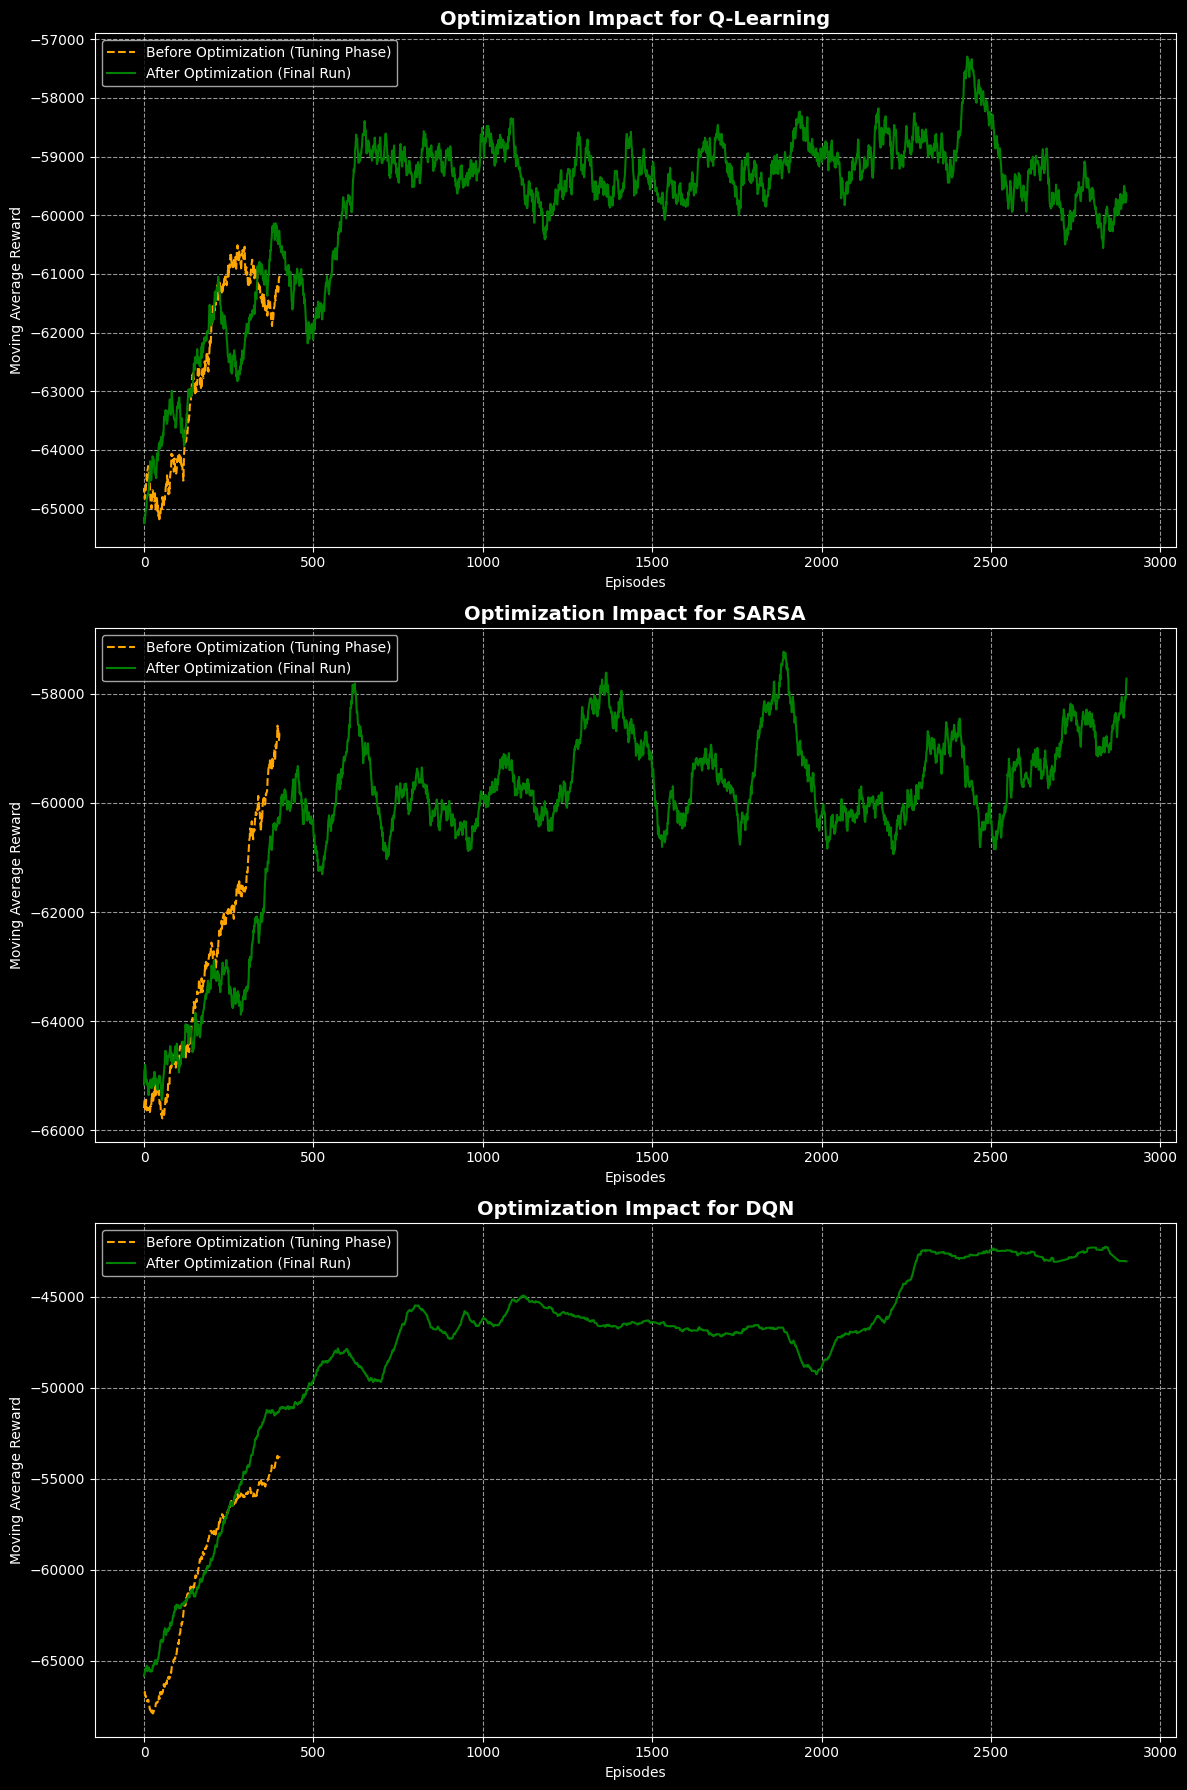

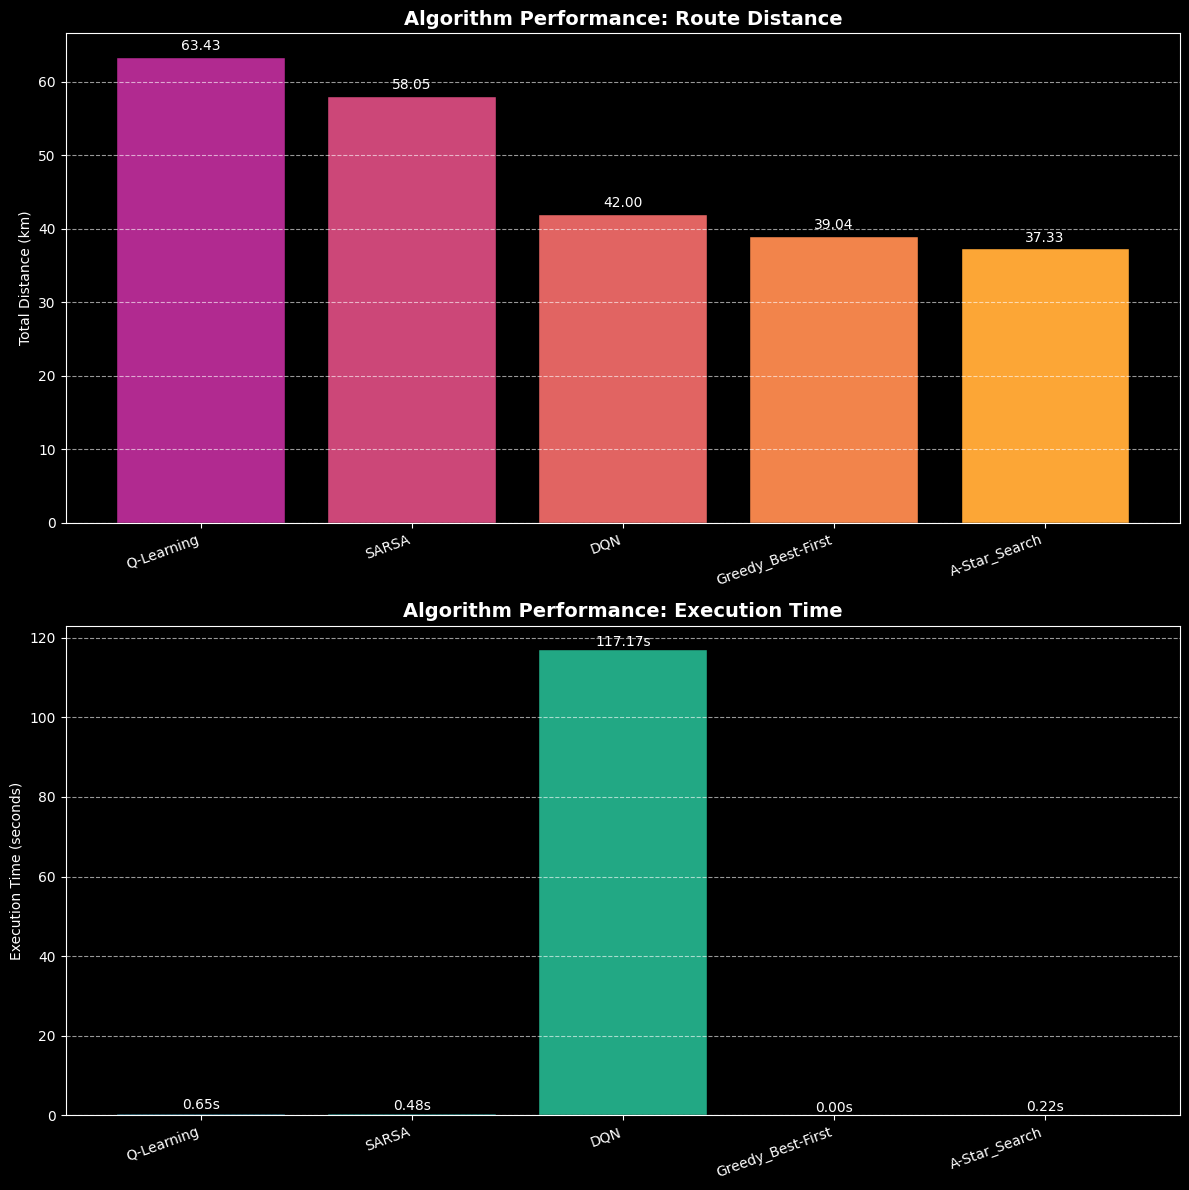

    ✓ Interactive map saved to visualisations\best_overall_route_middlesbrough.html

Requesting AI-Powered Analysis from Google


Of course. As an expert in reinforcement learning and logistics optimization, here is a comprehensive analysis of the provided results.

### **Analysis of Delivery Route Optimization Results**

This analysis evaluates five different algorithms on a 15-location Vehicle Routing Problem (VRP) in Middlesbrough. The objective is to find the shortest route starting from and returning to the depot, visiting all other locations once.

---

### 1. PERFORMANCE SUMMARY

**Winner: A-Star Search**

A-Star Search is the unequivocal winner, delivering the best performance across the most critical metrics for logistics operations.

*   **Optimal Route Distance:** It discovered the shortest possible route at **37.33 km**. This is the single most important factor for reducing operational costs (fuel, vehicle wear, driver time).
*   **Excellent Computational Efficiency:** The algorithm completed its search in just **0.22 seconds**. This is extremely fast and suitable for real-time applications, such as re-routing vehicles mid-journey in response to new orders or traffic incidents.

While **Greedy Best-First Search** was computationally faster (virtually instantaneous), its route was **4.6% longer** than A-Star's. This small time saving does not justify the extra operational cost incurred on every single trip.

The Reinforcement Learning (RL) agents performed significantly worse. The best of them, **DQN**, produced a route that was **12.5% longer** than A-Star's and took over 117 seconds to compute, making it impractical for dynamic operations. The simpler RL agents, **Q-Learning** and **SARSA**, produced highly suboptimal routes that were **70% and 56% longer**, respectively.

---

### 2. ALGORITHM COMPARISON

This problem highlights the classic trade-offs between classical search algorithms and modern reinforcement learning approaches.

#### **Informed Search (A-Star, Greedy) vs. Reinforcement Learning (Q-Learning, SARSA, DQN)**

*   **World Model:** Informed search algorithms like A-Star require a complete model of the environment upfront—in this case, the distance matrix between all locations. RL algorithms are "model-free" and can theoretically learn optimal behavior through trial and error without this complete knowledge. However, for a static VRP where distances are known, the primary advantage of being model-free is negated.
*   **Optimality:** A-Star, with an admissible heuristic, is **guaranteed to find the optimal solution**. This is a powerful assurance for fixed-cost problems. RL algorithms offer no such guarantee; they aim to find a "good" policy through approximation, which may or may not be the true optimum. The results here clearly show A-Star's optimality prevailing.
*   **Sample & Tuning Efficiency:** This is RL's most significant weakness in this context.
    *   **Sample Inefficiency:** Q-Learning and SARSA required thousands of simulated delivery runs (episodes) to learn, yet still converged to poor solutions. This suggests the state-action space is too large for these tabular methods to explore effectively within the given training time.
    *   **Tuning Inefficiency:** DQN performed better because it uses a neural network to generalize across states, but it introduces significant tuning complexity (network architecture, learning rate, replay buffer size, exploration strategy). The long computation time (117 seconds) is a direct result of the neural network's forward passes during decision-making.

#### **Trade-offs Within Algorithm Classes**

*   **A-Star vs. Greedy:** This is a classic trade-off between optimality and speed. Greedy search always moves to the next-best-looking node based on a heuristic. This is fast but short-sighted and can lead to suboptimal paths, as seen here (39.04 km). A-Star balances the cost-so-far with the heuristic, ensuring it doesn't get trapped by early, seemingly good choices, thus finding the true shortest path (37.33 km). For a 15-location problem, A-Star's slight computational overhead is negligible and well worth the improved solution quality.
*   **Tabular RL (Q-Learning/SARSA) vs. Deep RL (DQN):** The abysmal performance of Q-Learning and SARSA is expected for a VRP. The number of possible states (current location + set of visited locations) is factorial in nature ($15! \approx 1.3 \times 10^{12}$), which is far too large to store in a simple Q-table. DQN's success (relative to other RL methods) comes from its ability to approximate the Q-value function, but it still fell short of the classical search methods.

---

### 3. BUSINESS IMPLICATIONS

Translating these results into business terms reveals significant financial and operational consequences.

*   **Direct Operational Costs:** The choice of algorithm directly impacts the bottom line. The **26.1 km difference** between the A-Star route (37.3 km) and the Q-Learning route (63.4 km) represents a **70% increase in distance per trip**. For a fleet of vehicles, this translates to drastically higher costs for:
    *   Fuel Consumption
    *   Vehicle Maintenance (tire wear, oil changes, etc.)
    *   Driver Wages (longer time on the road)
*   **Operational Agility:** An algorithm that takes nearly two minutes to run (DQN) is a bottleneck. A business cannot react quickly to new customer orders, cancellations, or traffic jams. The sub-second performance of A-Star enables **dynamic routing**, allowing for real-time adjustments that increase customer satisfaction and operational efficiency.
*   **Reliability and Predictability:** A-Star is a deterministic algorithm. Given the same inputs, it will always produce the same optimal route. This is crucial for planning, scheduling, and providing customers with reliable ETAs. RL policies can sometimes be stochastic, introducing variability that is undesirable in a standardized logistics process.
*   **Implementation & Maintenance Costs:** Implementing a well-known algorithm like A-Star is straightforward with many available libraries. Implementing and maintaining a DQN agent requires specialized machine learning expertise, a robust training infrastructure, and continuous monitoring, representing a much higher total cost of ownership.

---

### 4. RECOMMENDATIONS

**Primary Recommendation: Deploy A-Star Search.**

For the problem as defined (a static VRP with a known number of locations and distances), A-Star Search is the superior choice and should be implemented immediately.

*   **Reasoning:** It provides the optimal, lowest-cost route with a computation time that is more than sufficient for real-world operational needs, including dynamic re-routing. Its reliability and ease of implementation make it the most pragmatic and cost-effective solution.

**Secondary Recommendation: Investigate Reinforcement Learning for Dynamic Problems.**

Do not discard RL entirely. While it failed at this static problem, its true strength lies in handling **complex, dynamic environments with uncertainty**, where classical algorithms falter. A research and development track should explore using RL for problems involving:

*   **Real-time traffic fluctuations.**
*   **Stochastic customer demand (pop-up orders).**
*   **Variable service times at each location.**
*   **Learning driver behavior or location-specific access patterns.**

In such scenarios, an RL agent could learn a policy that is more robust and adaptive than a pre-calculated A-Star route.

---

### 5. IMPROVEMENTS

To build a more robust and effective optimization system, the following improvements should be considered:

1.  **Refine the RL Approach:** The current RL performance can be drastically improved.
    *   **Increase Training:** 3,500 total episodes is very low for a complex sequencing problem. Training should be extended to hundreds of thousands or even millions of episodes.
    *   **Advanced Algorithms:** Move beyond DQN to more modern architectures better suited for routing, such as **Policy Gradient methods (e.g., PPO) combined with Graph Neural Networks (GNNs)**, which can learn the underlying structure of the routing graph.
    *   **Hyperparameter Optimization:** Use automated tuning frameworks (e.g., Optuna, Ray Tune) to find the optimal set of hyperparameters for the RL agents.

2.  **Enrich the Environment Model:** The current problem is a simplified abstraction. To increase real-world accuracy, the model should be expanded to include:
    *   **Time Windows:** Customers often require deliveries within a specific timeframe.
    *   **Vehicle Capacity:** Routes must be constrained by how much a vehicle can carry.
    *   **Real-Time Traffic:** Integrate with a service like the Google Maps API to use live traffic data instead of static network distances.
    *   **Multi-Vehicle Routing:** Expand the problem from a single-vehicle TSP to a multi-vehicle VRP, which is more common in logistics.

3.  **Explore Hybrid Approaches:** Combine the strengths of both methodologies.
    *   **RL-Guided Heuristics:** Use a trained RL model to generate a powerful, context-aware heuristic for the A-Star algorithm, potentially speeding up its search in much larger state spaces.
    *   **Large-Scale + Local Search:** Use a fast heuristic or a simple RL policy to generate an initial "good" solution, then use a local search algorithm (like 2-opt) to refine and optimize it.


Script finished.


In [6]:
# --- CONFIGURATION ---
CITY = "Middlesbrough"
NUM_PARCELS = 20
DISTANCE_METRIC = 'network'
NUM_EPISODES_TUNE = 500
NUM_EPISODES_FINAL = 3000
OUTPUT_DIR = "visualisations"
load_dotenv()

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"""
Delivery Route Optimization Analysis
------------------------------------
City: {CITY}
Number of Parcels: {NUM_PARCELS}
Distance Metric: {DISTANCE_METRIC} (Real road network)
RL Tuning Episodes: {NUM_EPISODES_TUNE}
RL Final Episodes: {NUM_EPISODES_FINAL}
""")

# --- 1. SETUP ENVIRONMENT ---
if not OSMNX_AVAILABLE:
    exit("OSMnx is required for 'network' distance metric. Please install it and try again.")

# Initialize the AI explainer to use for location generation
explainer = GoogleAIModelExplainer()
env = None

# Attempt to generate locations using AI
if explainer.available:
    print("\nAttempting to generate realistic locations using Google AI...")
    ai_addresses = explainer.generate_locations_for_city(CITY, NUM_PARCELS + 1)
    if ai_addresses:
        print("  ✓ Successfully generated addresses from AI.")
        env = DeliveryEnvironment(addresses=ai_addresses, city_name=CITY, distance_metric=DISTANCE_METRIC)
    else:
        print("  ✗ AI failed to return valid addresses. Falling back to random locations.")

# Fallback to random locations if AI fails or is unavailable
if env is None:
    print("  Generating random locations as a fallback...")
    locations_coords = generate_random_locations(CITY, NUM_PARCELS + 1)
    if locations_coords is None:
        exit("Failed to generate random locations. Exiting.")
    env = DeliveryEnvironment(locations=locations_coords, city_name=CITY, distance_metric=DISTANCE_METRIC)

print(f"\n  ✓ Environment ready. Matrix shape: {env.distance_matrix.shape}")

# --- 2. INITIALIZE AGENTS ---
rl_agents = {
    "Q-Learning": QLearningAgent(action_space=list(range(env.num_locations)), alpha=0.1, gamma=0.9, epsilon=1.0),
    "SARSA": SarsaAgent(action_space=list(range(env.num_locations)), alpha=0.1, gamma=0.9, epsilon=1.0),
    "DQN": DQNAgent(state_size=env.get_state_size(), action_size=env.num_locations, learning_rate=0.001, epsilon=1.0),
}
informed_search_agents = {
    "Greedy_Best-First": GreedyBestFirstSearchAgent(),
    "A-Star_Search": AStarAgent(),
}
all_agents = {**rl_agents, **informed_search_agents}

# --- 3. RL AGENT TUNING PHASE ---
print("\n" + "=" * 50)
print("Phase 1: RL Agent Tuning")
print("=" * 50)
initial_reward_histories = {}
for name, agent in rl_agents.items():
    print(f"  Tuning {name} for {NUM_EPISODES_TUNE} episodes...")
    initial_reward_histories[name] = train_agent(agent, env, NUM_EPISODES_TUNE, isinstance(agent, DQNAgent))

# --- 4. MODEL OPTIMIZATION & FINAL RUN ---
print("\n" + "=" * 50)
print("Phase 2: Optimization and Final Run")
print("=" * 50)
final_results = {}
best_route_info = {"agent": None, "route": [], "distance": float('inf')}
final_reward_histories = {}

# Define optimized hyperparameters
optimized_params = {
    "Q-Learning": {'alpha': 0.5, 'gamma': 0.95},
    "SARSA": {'alpha': 0.2, 'gamma': 0.98},
    "DQN": {'learning_rate': 0.0005}
}

for name, agent in all_agents.items():
    print(f"\n--- Processing Agent: {name} ---")
    start_time = time.time()

    if isinstance(agent, InformedSearchAgent):
        route, distance = agent.solve(env)
    else:  # RL Agent
        print(f"  Applying optimized parameters and running for {NUM_EPISODES_FINAL} episodes...")
        params = optimized_params.get(name, {})
        agent_class = agent.__class__
        if name == "DQN":
            final_agent = agent_class(state_size=env.get_state_size(), action_size=env.num_locations, **params)
        else:
            final_agent = agent_class(action_space=list(range(env.num_locations)), **params)

        final_reward_histories[name] = train_agent(final_agent, env, NUM_EPISODES_FINAL,
                                                   isinstance(final_agent, DQNAgent))
        print("  Evaluating final policy...")
        route, distance = evaluate_agent(final_agent, env, isinstance(final_agent, DQNAgent))

    duration = time.time() - start_time
    final_results[name] = {
        "total_distance_km": distance,
        "route_length": len(route),
        "duration_sec": duration,
        "route": route
    }
    print(f"  ✓ Finished in {duration:.2f}s. Route Distance: {distance:.2f} km")

    # Plot the route for this specific agent
    agent_map_filename = os.path.join(OUTPUT_DIR, f"route_{name.replace(' ', '_')}.html")
    plot_delivery_route(env, route, agent_map_filename, agent_name=name)

    if distance < best_route_info["distance"]:
        best_route_info = {"agent": name, "route": route, "distance": distance}
        print(f"  >>> New best route found by {name}! <<<")

# --- 5. VISUALIZE AND EXPORT RESULTS ---
print("\n" + "=" * 50)
print("VISUALIZING AND EXPORTING RESULTS")
print("=" * 50)

plot_optimization_impact(initial_reward_histories, final_reward_histories, OUTPUT_DIR)
plot_performance_comparison(final_results, OUTPUT_DIR)

# Save a separate map for the best overall route
best_map_filename = os.path.join(OUTPUT_DIR, f"best_overall_route_{CITY.lower()}.html")
plot_delivery_route(env, best_route_info["route"], best_map_filename,
                    agent_name=f"Best Route ({best_route_info['agent']})")

# --- 6. FINAL AI-POWERED ANALYSIS ---
if explainer.available:
    print("\n" + "=" * 50)
    print("Requesting AI-Powered Analysis from Google")
    print("=" * 50)

    env_config = env.get_environment_summary()
    env_config["rl_tuning_episodes"] = NUM_EPISODES_TUNE
    env_config["rl_final_episodes"] = NUM_EPISODES_FINAL
    env_config["best_agent"] = best_route_info["agent"]
    env_config["best_distance_km"] = best_route_info["distance"]

    analysis = explainer.analyze_performance(final_results, env_config)
    display(Markdown(analysis))
else:
    print("\nGoogle AI Explainer not available. Skipping analysis.")

print("\nScript finished.")